In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
u0=4*math.pi*10**-7 #vacuum permeability
rpoCopper=1.68*10**-8

VERBOSE= False
class Cap:
    v0=0
    v=0 # time domain vector
    c=0 #uF
    esr=0
    def __init__(self,voltage,capacitance,esr=0):
        self.esr=esr
        self.v0=voltage
        self.v=self.v0
        self.c=capacitance
    def getEnergy(self):
        return 0.5*(self.c*10**-6)*self.v**2
class Bullet:
    d=0
    v=0
    a=0
    def __init__(self,m,length,diameter,ur=6.3*10**-3,saturation=0.75):
        self.m=m #grams
        self.length=length #mm
        self.diameter=diameter #mm
        self.ur=ur #relative permeability
        self.caliber=np.pi*(self.diameter/2)**2  # crosssection area
        self.saturation=saturation   #saturation (Tesla)
    def getMaxForce(self):
        return self.saturation**2*self.caliber*10**-6/2/u0

class Coil:
    #default values
    L=0  # uH
    R=0  # Ohm
    n=0  # turns
    width=0   #mm
    innerDia=5  #mm
    outerDia=5  #mm
    gauge=20  #AWG
    AWGLUT={1:7.3481,2:6.5437,3:5.8273,4:5.1894,5:4.6213,6:4.1154,7:3.6649,8:3.2636,9:2.9064,10:2.5882,11:2.3048,12:2.0525,13:1.8278,14:1.6277,15:1.4495,16:1.2908,17:1.1495,18:1.0237,19:0.9116,20:0.8118,21:0.7229,22:0.6438,23:0.5733,24:0.5106,25:0.4547,26:0.4049,27:0.3606,28:0.3211,29:0.2859,30:0.2546,31:0.2268,32:0.2019,33:0.1798,34:0.1601,35:0.1426,36:0.1270,37:0.1131,38:0.1007,39:0.0897,40:0.0799}
    def __init__(self,n,innerDia,width,gauge): #input, n:turns, innerDia:inner diameter(mm), length(mm), gauge(awg)
        self.n=n
        self.width=width
        self.innerDia=innerDia
        self.gauge=gauge
        self.wireDia=self.AWGLUT[self.gauge]
        self.tpl=math.ceil(self.width/self.wireDia) # turns per layer
        self.width=self.tpl*self.wireDia # actual width
        self.layers=math.ceil(self.n/self.tpl)
        self.outerDia=self.innerDia+2*(self.layers*self.wireDia)    # return inner_dia + 2 * layer * wire_dia

        remainingTurns=self.n
        self.wireLength=0
        for layer in range(self.layers):
            D=self.innerDia+2*layer*self.wireDia
            if remainingTurns>= self.tpl:
                LayerL=self.tpl**2*u0*(D*10**-3/2)*(np.log(8*D/self.wireDia)-2)
                layerl=D*math.pi*self.tpl
            else:
                LayerL=remainingTurns**2*u0*(D*10**-3/2)*(np.log(8*D/self.wireDia)-2)
                layerl=D*math.pi*remainingTurns
#             print(LayerL, layerl)
            self.L+= LayerL
            self.wireLength +=layerl
            remainingTurns=remainingTurns-self.tpl
        self.L=self.L * 10**6 # H to uH
        self.R=rpoCopper*self.wireLength*10**-3/(math.pi*(self.wireDia*10**-3/2)**2)
        


'''
Plan: emulate di/dt on the on and off ramp, cut off needs to happen before projectile hits center of the coil to minimize pullback
need to emulate how early onramp needs to kick it to ensure enough time has passed to kick into the full force

'''
class Stage():
    def __init__(self,coil,capacitor,bullet,offset=20):
        self.coil=coil
        self.capacitor=capacitor
        self.offset=offset
        self.bullet=bullet

    def simulate(self,duration,runcycle,plot=False):
        
        # Iconstant= battery supplied constant corruent (Assume 0.2 Ohm PD path)
        Iconstant=self.capacitor.v0/(self.coil.R+0.2)
        timestep=duration/runcycle;

        tTrain=np.linspace(0,duration,runcycle)
        
        Icharging=Iconstant*(1-np.exp(-tTrain*(self.coil.R+0.2)/self.coil.L))
        maxforce=self.bullet.getMaxForce()
       
        plt.plot(Iactual)
        #simulate force transient
        iterr = iter(range(runcycle))
        next(iterr) # skip first term
        for i in iterr:
            if dis[i-1]*1000<self.offset:
                force[i]=(self.coil.n*Iflywheel[i])**2*u0*self.bullet.caliber*10**-6/2/((self.offset*10**-3-dis[i-1]))**2
                if VERBOSE:
                    print('before %.4f %.4f %d',dis[i-1],force[i],i)
            elif (self.offset-dis[i-1]*1000 <= 0 and dis[i-1]*1000-self.offset <= self.coil.width ): # if in coil
                force[i]=(.5-((dis[i-1]*10**3-self.offset)/self.coil.width))*2* (self.bullet.ur*u0*self.coil.n*Iflywheel[i])**2*self.bullet.caliber*10**-6/2/u0
                if VERBOSE:
                    print('within %.4f %.4f %d',dis[i-1],.5-((dis[i-1]*10**3-self.offset)/self.coil.width),i)
            elif dis[i-1]*1000-self.offset-self.coil.width>0:
                force[i]=-(self.coil.n*Iflywheel[i])**2*u0*self.bullet.caliber*10**-6/2/((dis[i-1]-self.offset*10**-3-self.coil.width*10**-3))**2
                if VERBOSE:
                    print('beyond %.4f %.4f %d',dis[i-1],force[i],i)

            force_raw[i]=force[i];
            if force[i]>0:
                force[i] = min(force[i],maxforce);
            else:
                force[i] = -min(-force[i],maxforce);

            acc[i]=force[i]/(self.bullet.m*10**-3);
            v[i]=v[i-1]+acc[i]*timestep;
            dis[i]=dis[i-1]+v[i]*timestep;
        plt.plot(Iflywheel)
        plt.show()

        outenergy=0.5*(self.bullet.m*10**-3)*v[-1]**2;
        inenergy=self.capacitor.getEnergy()
        return outenergy/inenergy



In [2]:
myCoil=Coil(50,5,25,24)#n,innerDia,width,gauge
print(myCoil.L)
ironBall=Bullet(2.9,19,4.76) #m,length,diameter,ur=6.3*10**-3,saturation=0.75):
#2.9g, 19mm long, 4.76 mm diameter
stage1Cap=Cap(20,1200,0.1) #,voltage,capacitance,esr=0):

stage1=Stage(myCoil,stage1Cap,ironBall,1) #1mm offset
effi=stage1.simulate(0.01,1000)
print(effi)

1.780930169679983e-05 769.6902001294993
9.635500639389152e-09 18.916157685794865
17.81893719743922


NameError: name 'Iactual' is not defined

In [3]:
tTrain=np.linspace(0,0.05,500)
Icharging=60*(1-np.exp(-tTrain*(.1+0.2)/0.005))

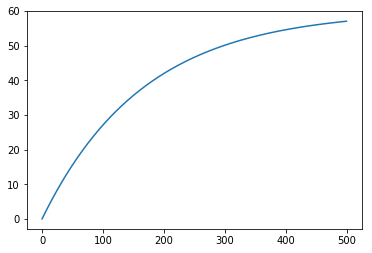

In [4]:
plt.plot(Icharging)

In [5]:
maxF=ironBall.getMaxForce()

In [6]:
maxF

3.9827812499999995

In [7]:
I=1(ironBall.ur*80*I)**2*ironBall.caliber*10**-6/2/u0

1.798560288